ß
#### Arquitetura de Redes Neurais Long Short Term Memory (LSTM) chuva para o Sistema Cantareira



In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import torch
import seaborn as sns
import torch.optim as optim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [45]:
# Semente (seed) para a geração de números aleatórios e obter resultados reproduzíveis em diferentes execuções do código
tf.random.set_seed(1234)
print(tf.random.uniform([1], seed=1))  # generates 'A1'
print(tf.random.uniform([1], seed=1))  # generates 'A2'

tf.Tensor([0.1689806], shape=(1,), dtype=float32)
tf.Tensor([0.7539084], shape=(1,), dtype=float32)


In [46]:
# Utilizar recursos da GPU, caso haja.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


In [47]:
df_SABESP = pd.read_excel(
    r'https://github.com/GMerencio/previsao-sistema-cantareira/raw/main/SABESP-sistemas_produtores.xlsx')

dfSabesp = df_SABESP.groupby(['Data'], as_index=False).sum(numeric_only=True)

df1 = pd.DataFrame()
#df1['ds'] = dfSabesp['Data']
df1['y'] = dfSabesp['Chuva (mm)']

In [48]:
dfSabesp

,Data,Nível (m),Volume (hm³),Volume (%),Q Jusante (m³/s),Q Natural (m³/s),Chuva (mm)
0,2000-01-01,3181.83,364.889117,173.856164,10.16,70.885286,123.6
1,2000-01-02,3182.31,370.080351,195.805609,10.18,94.863726,116.4
2,2000-01-03,3182.55,376.466840,192.263964,7.29,108.207695,140.7
3,2000-01-04,3182.90,387.326973,189.617341,6.34,162.935989,74.9
4,2000-01-05,3183.43,402.462028,188.935016,6.33,211.604248,103.6
...,...,...,...,...,...,...,...
8486,2023-03-27,3187.46,795.162116,180.094749,1.85,42.724010,22.4
8487,2023-03-28,3187.47,796.396238,180.172835,1.85,40.153825,0.0
8488,2023-03-29,3187.36,797.084667,179.183104,1.85,35.615927,1.2
8489,2023-03-30,3187.29,798.879778,179.783851,1.85,49.586739,55.2


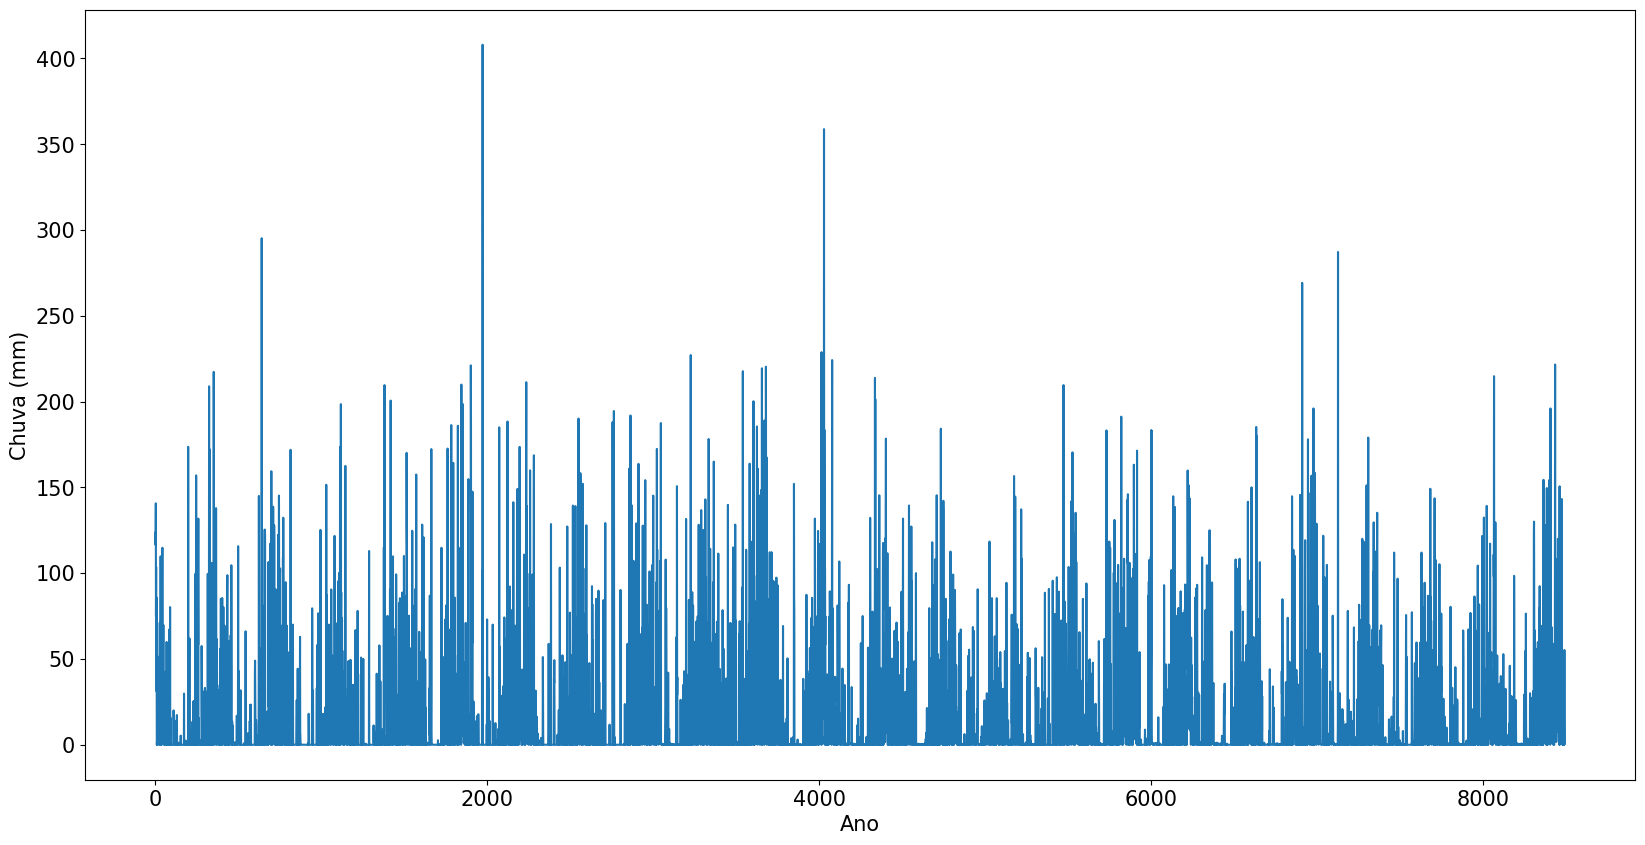

In [49]:
dataset = df1.values
dataset = dataset.astype('float64')
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(20,10))
plt.xlabel('Ano', fontsize=15)
plt.ylabel('Chuva (mm)', fontsize=15)
plt.plot(dataset)
plt.show()

#fig = plt.subplots(figsize=(18, 9))
#sns.lineplot(x='ds', y='y', data=df1).set(title='Volume [hm³] do sistema Cantareira', xlabel='Data', ylabel='Volume (hm³)')
#sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

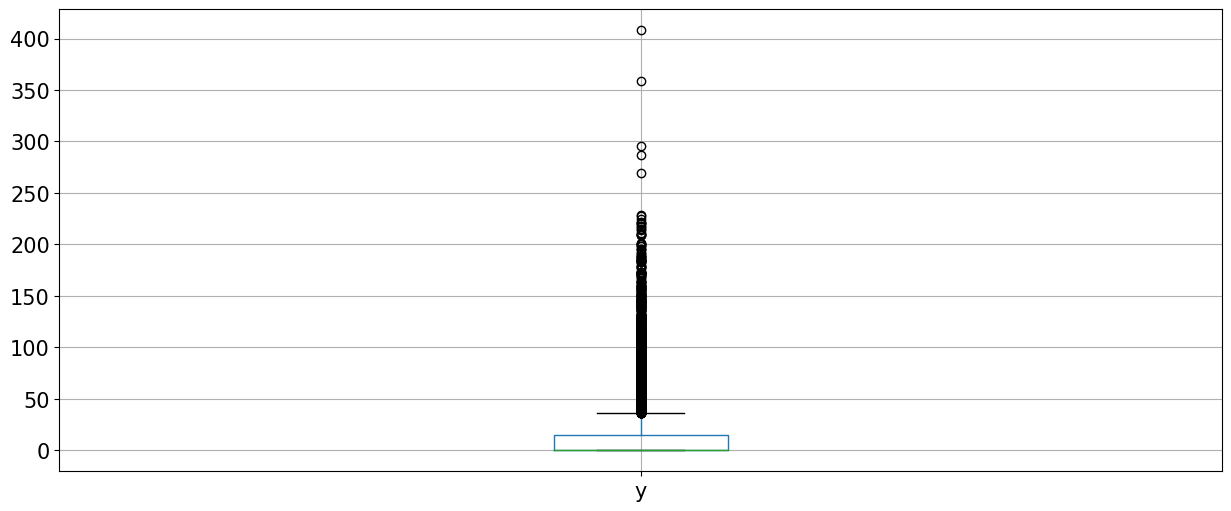

In [51]:
# gera um bloxplot para cada atributo
df1.boxplot(figsize=(15,6))
plt.show()

# Modelo Preditivo (LSTM)

In [52]:
# normalização do dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

In [53]:
# Separar o conjuntos de dados de treinamento e teste para modelagem.
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6792 1699


In [54]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [55]:
# reshape into X=t and Y=t+1
look_back = 800
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [56]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [57]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
opt = SGD(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2, validation_split=0.3)

Epoch 1/50


2023-05-26 20:39:56.246793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 20:39:56.248383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 20:39:56.249478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2097/2097 - 7s - loss: 0.0305 - val_loss: 0.0234 - 7s/epoch - 3ms/step
Epoch 2/50
2097/2097 - 5s - loss: 0.0287 - val_loss: 0.0213 - 5s/epoch - 2ms/step
Epoch 3/50
2097/2097 - 5s - loss: 0.0284 - val_loss: 0.0208 - 5s/epoch - 2ms/step
Epoch 4/50
2097/2097 - 5s - loss: 0.0283 - val_loss: 0.0207 - 5s/epoch - 2ms/step
Epoch 5/50
2097/2097 - 5s - loss: 0.0280 - val_loss: 0.0207 - 5s/epoch - 3ms/step
Epoch 6/50
2097/2097 - 5s - loss: 0.0279 - val_loss: 0.0213 - 5s/epoch - 2ms/step
Epoch 7/50
2097/2097 - 5s - loss: 0.0276 - val_loss: 0.0227 - 5s/epoch - 3ms/step
Epoch 8/50
2097/2097 - 5s - loss: 0.0275 - val_loss: 0.0204 - 5s/epoch - 3ms/step
Epoch 9/50
2097/2097 - 5s - loss: 0.0275 - val_loss: 0.0211 - 5s/epoch - 2ms/step
Epoch 10/50
2097/2097 - 5s - loss: 0.0273 - val_loss: 0.0202 - 5s/epoch - 2ms/step
Epoch 11/50
2097/2097 - 5s - loss: 0.0273 - val_loss: 0.0203 - 5s/epoch - 2ms/step
Epoch 12/50
2097/2097 - 5s - loss: 0.0270 - val_loss: 0.0276 - 5s/epoch - 2ms/step
Epoch 13/50
2097/2097 - 

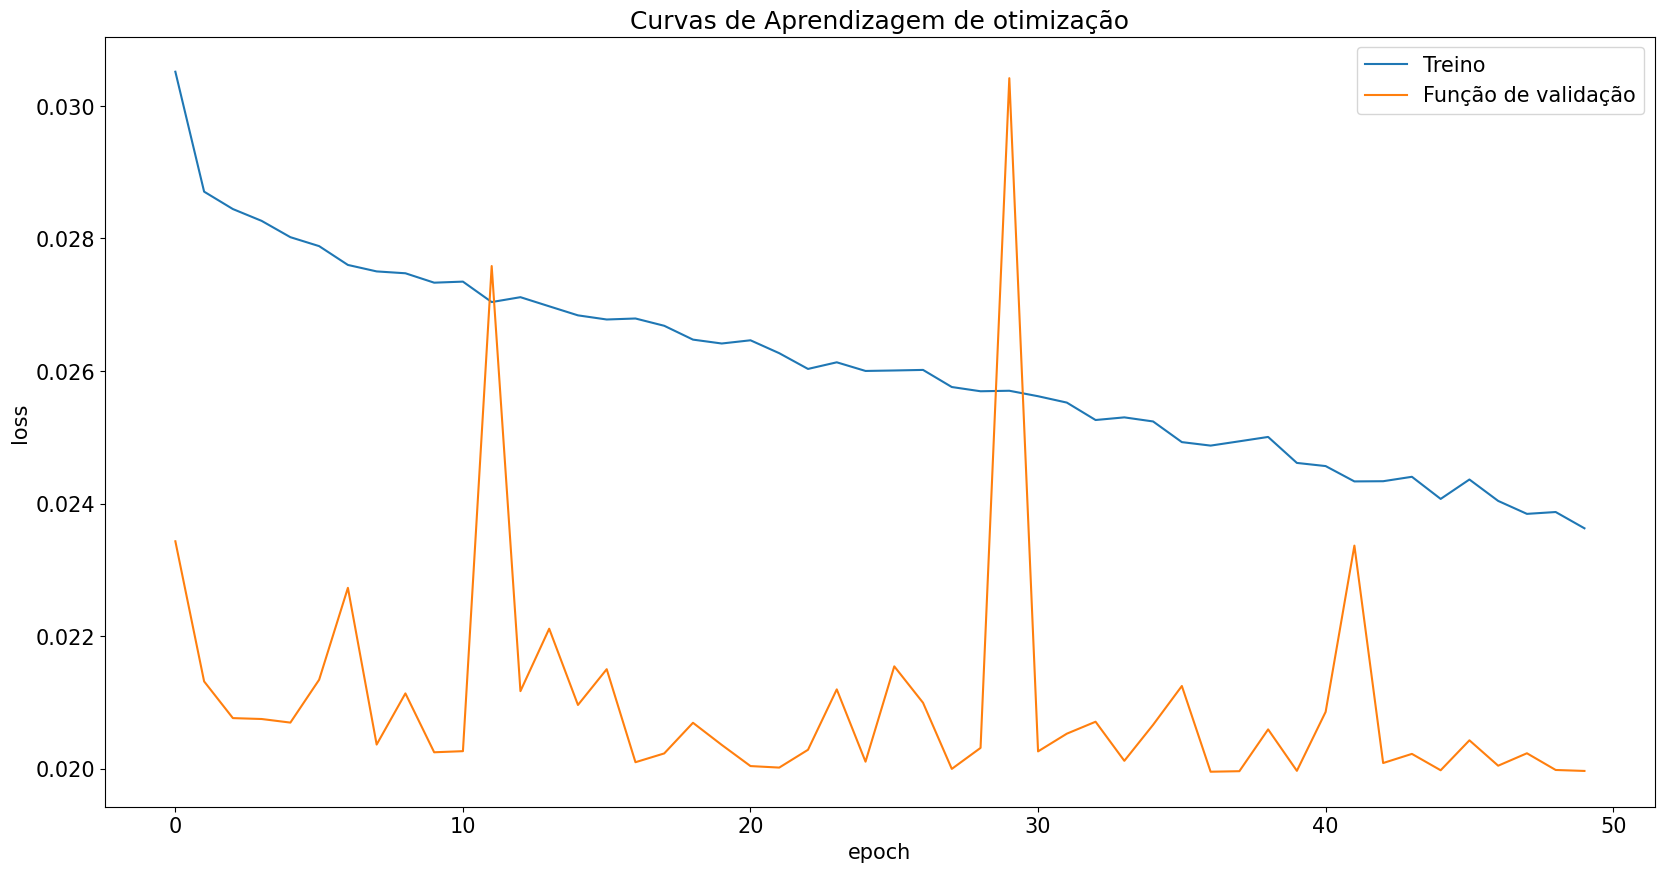

In [61]:
# plot train and validation loss
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Curvas de Aprendizagem de otimização')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Treino', 'Função de validação'], loc='upper right')
plt.show()

In [63]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

29/29 [==============================] - 0s 2ms/step


ValueError: Found array with dim 3. None expected <= 2.

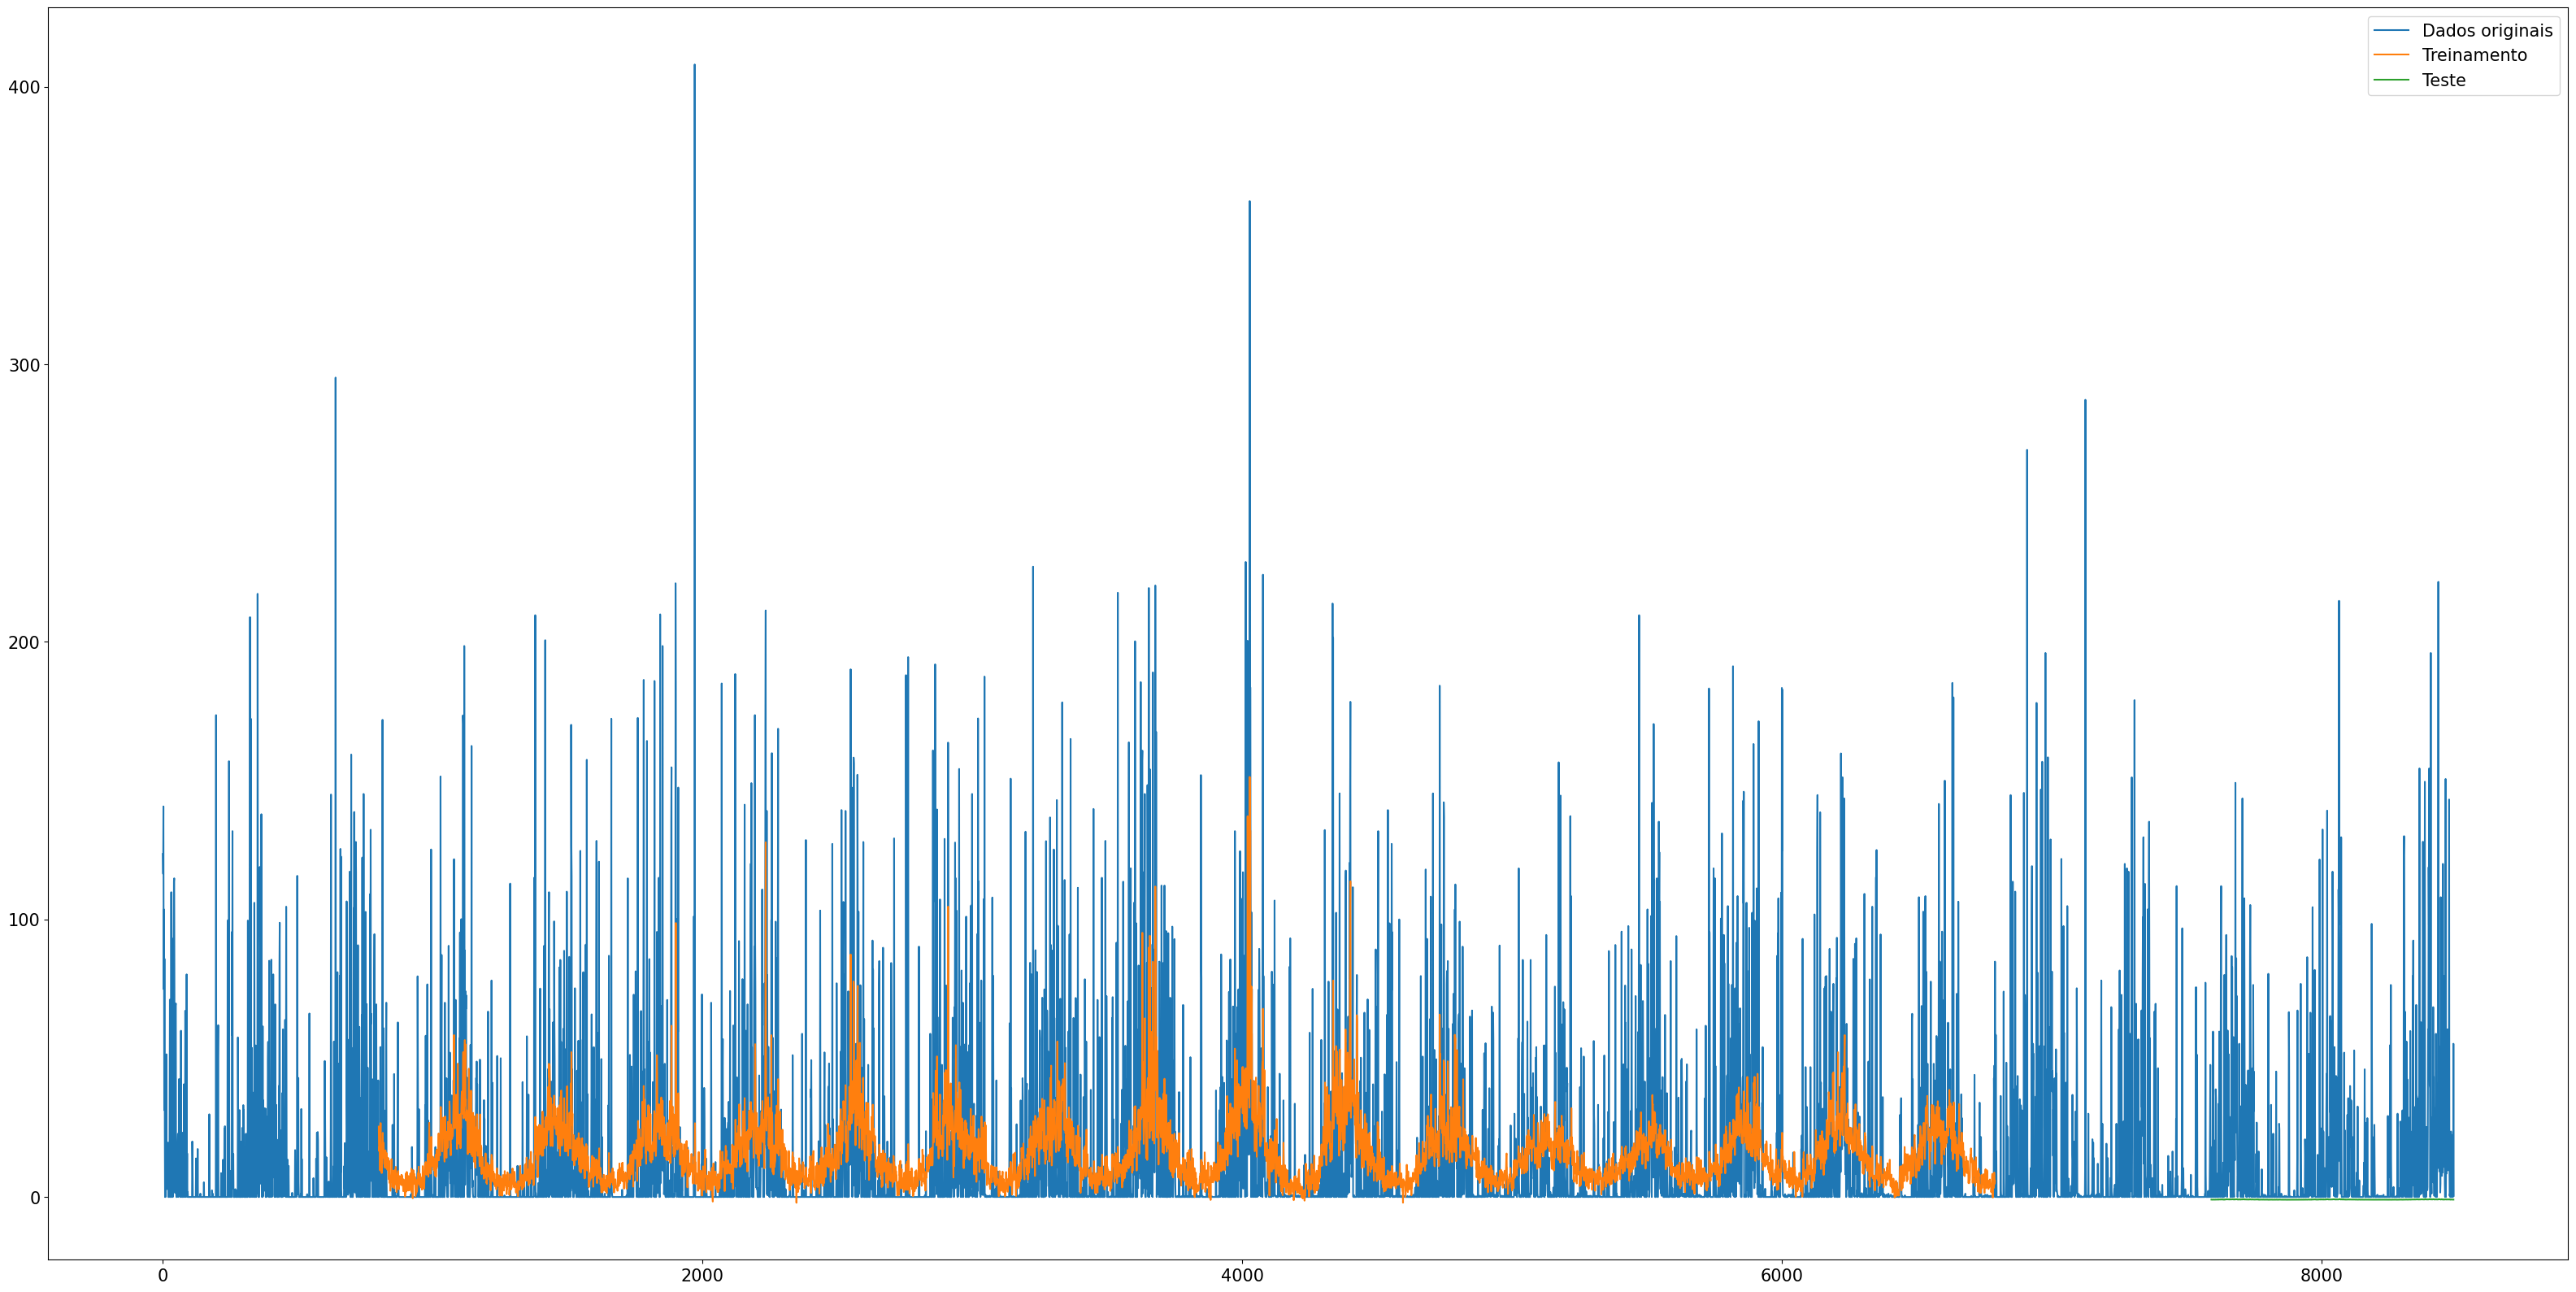

In [64]:
# shift train predictions for plotting
plt.figure(figsize=(40,20))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.rcParams['font.size'] = '15'
plt.plot(scaler.inverse_transform(dataset), label='Dados originais')
plt.plot(trainPredictPlot, label='Treinamento')
plt.plot(testPredictPlot, label='Teste')
plt.legend()
plt.show()

In [41]:
future_periods = 2000 # definição do número de passos futuros
last_sequence = testX[-1]

future_predictions = []
for _ in range(future_periods):
    last_sequence = np.reshape(last_sequence, (1, 1, look_back))
    next_prediction = model.predict(last_sequence)
    future_predictions.append(next_prediction[0, 0])
    last_sequence = np.concatenate((last_sequence[:, :, 1:], next_prediction.reshape(1, 1, 1)), axis=2)

# Inverter a escala das previsões futuras
future_predictions = scaler.inverse_transform([future_predictions])

# Exibir as previsões futuras
print("Previsões futuras:")
for i, prediction in enumerate(future_predictions[0]):
    print(f"Período {i+1}: {prediction}")

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Previsões futuras:
Período 1: 11.266000270843506
Período 2: 11.205933094024658
Período 3: 11.73107099533081
Período 4: 7.698180198669434
Período 5: 9.961302280426025
Período 6: 14.772756099700928
Período 7: 15.306989192962646
Período 8: 17.456907749176025
Período 9: 9.92090892791748
Período 10: 10.701125621795654
Período 11: 10.441864013671875
Período 12: 15.333642482757568
Período 13: 10.337099075317383
Período 14: 18.28187084197998
Período 15: 14.690558910369873
Período 16: 11.891404151916504
Período 17: 13.157824516296387
Período 18: 9.925894260406494
Período 19: 10.46224308013916
Período 20: 11.266194820404053
Período 21: 9.741145133972168
Período 22: 7.454652786254883
Período 23: 6.17266845703125
Período 24: 5.0061492919921875
Período 25: 9.331204891204834
Período 26: 9.440031051635742
Período 27: 3.9811649322509766
Período 28: 7.801145553588867
Período 29: 8.988821983337402
Período 30: 5.470976829528809
Período 31: 4.29740524291

In [42]:
# Calcular o erro do modelo nos dados de teste
test_predictions = model.predict(testX)
test_predictions = scaler.inverse_transform(test_predictions)
test_rmse = np.sqrt(np.mean((test_predictions - testY) ** 2))
print("Erro RMSE nos dados de teste:", test_rmse)

29/29 [==============================] - 0s 1ms/step
Erro RMSE nos dados de teste: 31.782186867396277


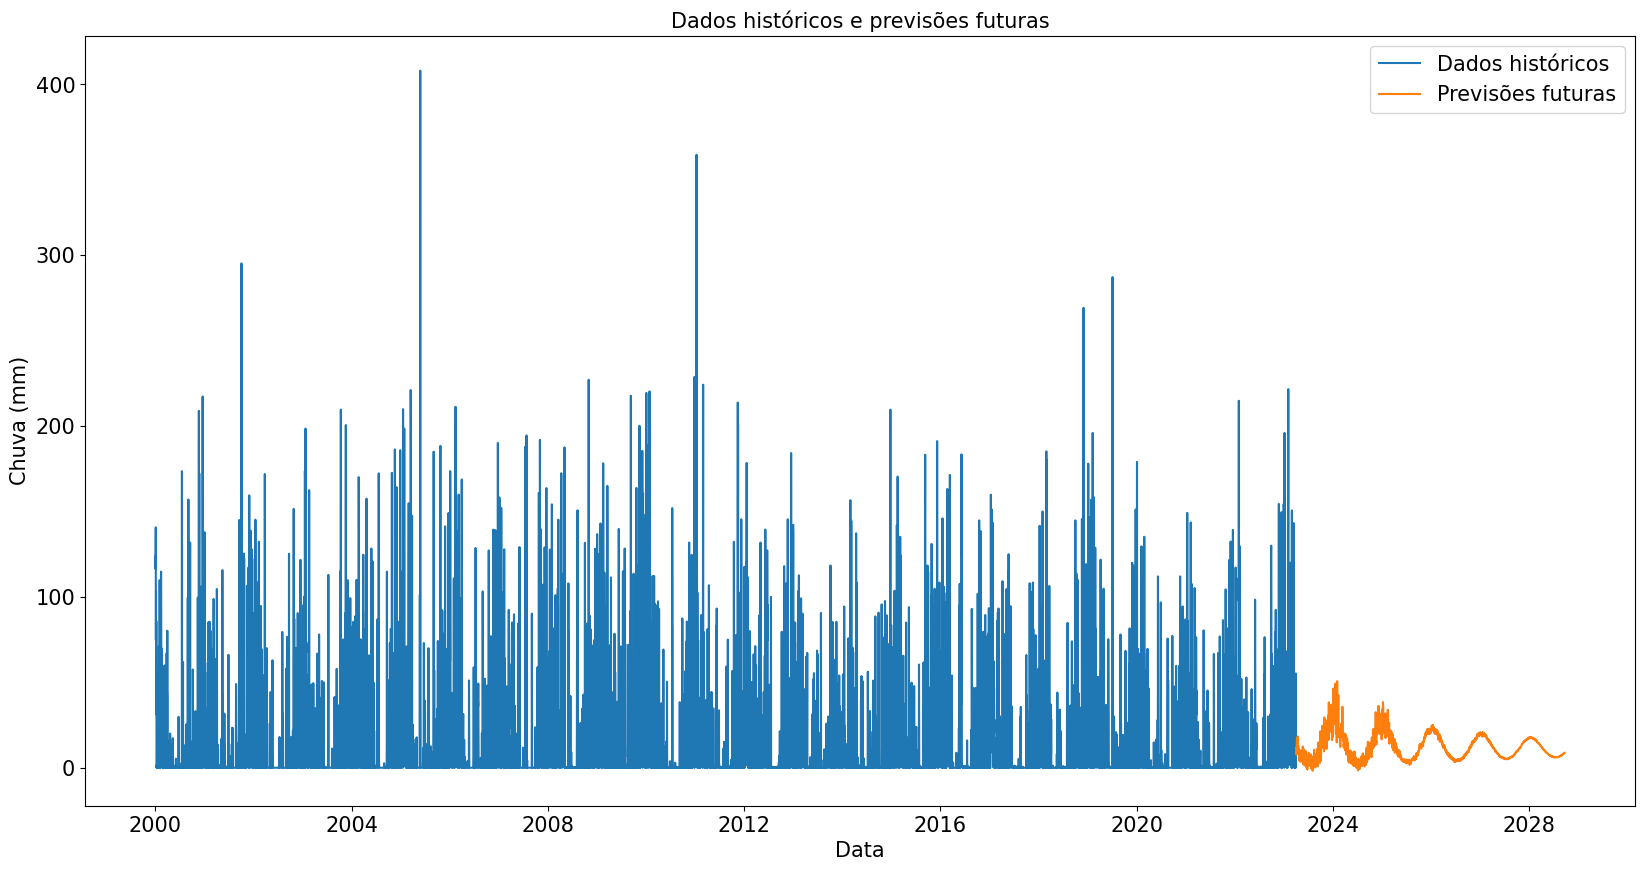

In [43]:
# Obter os índices das datas históricas
#dates = dfSabesp['Data'][:train_size+look_back]

# Criar os índices das datas futuras
#future_dates = pd.date_range(start=dates.iloc[-1], periods=future_periods+1)[1:]
future_dates = pd.date_range(start=dfSabesp['Data'].iloc[-1], periods=future_periods+1)[1:]

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(20, 10))
#plt.plot(dates, dfSabesp['Volume (hm³)'][:train_size+look_back], label='Dados históricos')
#plt.plot(future_dates, np.concatenate([dfSabesp['Volume (hm³)'][train_size+look_back-1:], future_predictions.flatten()]), label='Previsões futuras')
plt.plot(dfSabesp['Data'], dfSabesp['Chuva (mm)'], label='Dados históricos') 
plt.plot(future_dates, future_predictions.flatten(), label='Previsões futuras')
plt.xlabel('Data', fontsize = 15)
plt.ylabel('Chuva (mm)', fontsize = 15)
plt.title('Dados históricos e previsões futuras', fontsize = 15)
plt.legend()
plt.show()

# Desempenho do modelo: Curva ROC (Receiver Operating Characteristic)

In [12]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(testX).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, history)

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(trainX, trainY)

y_pred_rf = rf.predict_proba(testX)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(testY, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

#### Referências:  
<https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/>  
<http://surl.li/hfrzg>  
<https://didatica.tech/dados-de-treino-e-teste/>  
<https://runebook.dev/pt/docs/tensorflow/random/set_seed>  
https://keras.io/api/optimizers/  
https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/  
https://www.tutorialspoint.com/keras/keras_model_compilation.htm  
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/  